# RNN & LSTM & GRU - Recurrent Neural Nets
* https://www.youtube.com/watch?v=0_PgWWmauHk&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=20
* https://github.com/patrickloeber/pytorch-examples/tree/master/rnn-lstm-gru

# build in のPyTorch.nn.RNN
* MNISTデータセットを用いてRNNのsequence処理を学ぶ
* https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

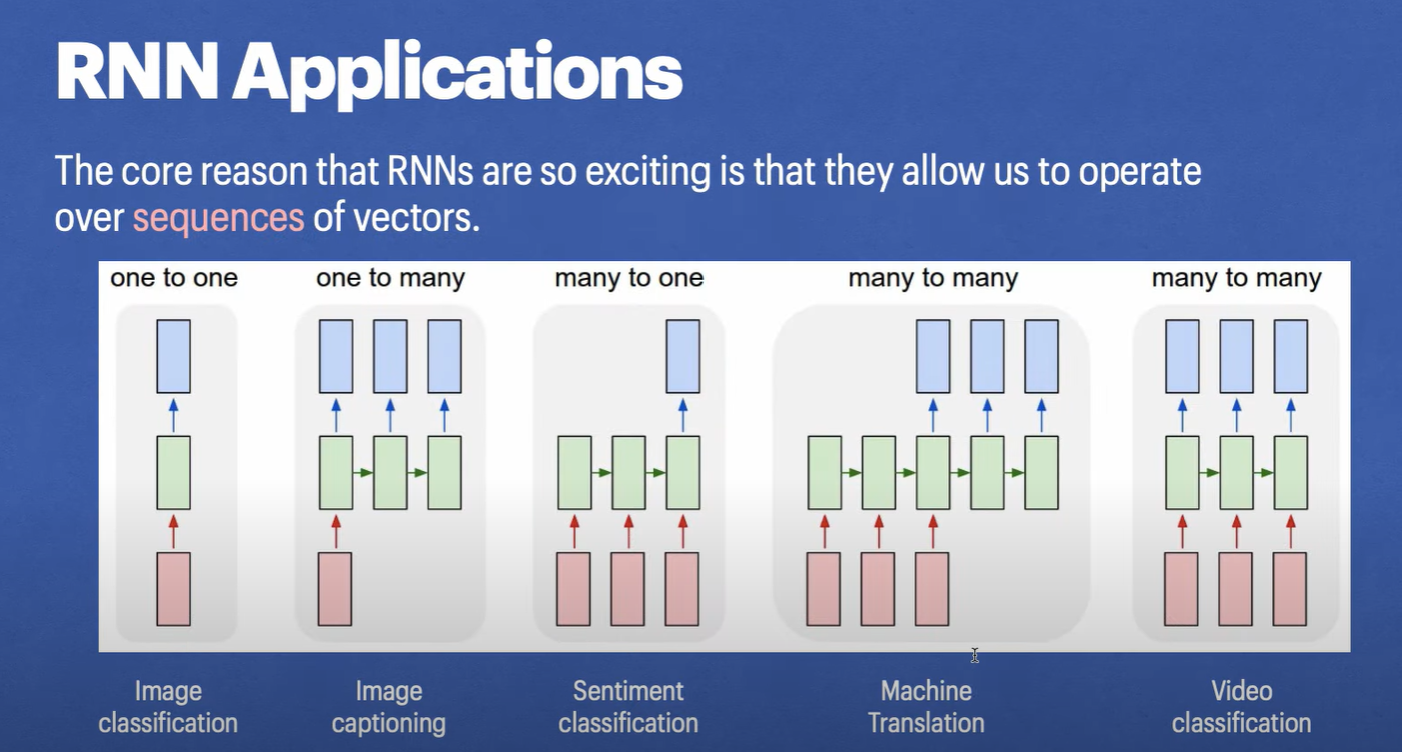

In [ ]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/study_DeepLearning/data/rnn_kinds.png')
im

* 上記のなかで、many to oneを適用する

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Devide configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Hyper-parameters
# input_size = 784 # 28*28 <- We treat image as sequence, so we treat one image dimension as one sequence
# and other image size as input or feature size
input_size = 28
sequence_length = 28

num_layers = 2
# ↑ defaultは1。 this means that we are stacking in this case two are RNN's together
# and the second RNN takes the output from the first RNN as input. This can further improve our model.

# hidden_size = 500
hidden_size = 128

num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [ ]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/study_DeepLearning/data/MNIST', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/study_DeepLearning/data/MNIST', train=False, transform=transforms.ToTensor(), download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 83504479.43it/s]


Extracting /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103623348.01it/s]

Extracting /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29464933.78it/s]


Extracting /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17688513.25it/s]


Extracting /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/study_DeepLearning/data/MNIST/MNIST/raw



In [ ]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # batch_first=True : batchをfirst dimensionに設定
    # x -> (batch_size, seq, input_size)
    self.fc = nn.Linear(hidden_size, num_classes) #最後のhidden_stateの値のみ必要

  def forward(self, x):
    # 最初のhidden_stateの値設定
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.rnn(x, h0)
    # out: batch_size, seq_length, hidden_size
    # out (N, 28, 128)
    out = out[:, -1, :] # 最後のhiden_stateの値のみ必要
    # out (N, 128)
    out = self.fc(out)
    return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [N, 1, 28, 28]
    # resize: [N, 28, 28]
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.9612
Epoch [1/2], Step [200/600], Loss: 0.7648
Epoch [1/2], Step [300/600], Loss: 0.6190
Epoch [1/2], Step [400/600], Loss: 0.6080
Epoch [1/2], Step [500/600], Loss: 0.3928
Epoch [1/2], Step [600/600], Loss: 0.4329
Epoch [2/2], Step [100/600], Loss: 0.2546
Epoch [2/2], Step [200/600], Loss: 0.4436
Epoch [2/2], Step [300/600], Loss: 0.2724
Epoch [2/2], Step [400/600], Loss: 0.1057
Epoch [2/2], Step [500/600], Loss: 0.2609
Epoch [2/2], Step [600/600], Loss: 0.1617


In [ ]:
# Test the model
# In the phase, we don't need to compute gradients (for memory dfficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value, index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')


Accuracy of the network on the 10000 test images: 93.63 %


# GRU(multi-layer gated recurrent unit)
* https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

In [ ]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # batch_first=True : batchをfirst dimensionに設定
    # x -> (batch_size, seq, input_size)
    self.fc = nn.Linear(hidden_size, num_classes) #最後のhidden_stateの値のみ必要

  def forward(self, x):
    # 最初のhidden_stateの値設定
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.gru(x, h0)
    # out: batch_size, seq_length, hidden_size
    # out (N, 28, 128)
    out = out[:, -1, :] # 最後のhiden_stateの値のみ必要
    # out (N, 128)
    out = self.fc(out)
    return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [N, 1, 28, 28]
    # resize: [N, 28, 28]
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.7164
Epoch [1/2], Step [200/600], Loss: 0.3276
Epoch [1/2], Step [300/600], Loss: 0.2293
Epoch [1/2], Step [400/600], Loss: 0.1903
Epoch [1/2], Step [500/600], Loss: 0.2274
Epoch [1/2], Step [600/600], Loss: 0.1815
Epoch [2/2], Step [100/600], Loss: 0.2233
Epoch [2/2], Step [200/600], Loss: 0.0984
Epoch [2/2], Step [300/600], Loss: 0.1418
Epoch [2/2], Step [400/600], Loss: 0.1744
Epoch [2/2], Step [500/600], Loss: 0.1612
Epoch [2/2], Step [600/600], Loss: 0.1625


In [ ]:
# Test the model
# In the phase, we don't need to compute gradients (for memory dfficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value, index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')


Accuracy of the network on the 10000 test images: 97.49 %


# LSTM(multi-layer long short-term memory)
* https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
# Fully connected neural network with one hidden layer
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # batch_first=True : batchをfirst dimensionに設定
    # x -> (batch_size, seq, input_size)
    self.fc = nn.Linear(hidden_size, num_classes) #最後のhidden_stateの値のみ必要

  def forward(self, x):
    # 最初のhidden_stateの値設定
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    # out: batch_size, seq_length, hidden_size
    # out (N, 28, 128)
    out = out[:, -1, :] # 最後のhiden_stateの値のみ必要
    # out (N, 128)
    out = self.fc(out)
    return out

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [N, 1, 28, 28]
    # resize: [N, 28, 28]
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.6398
Epoch [1/2], Step [200/600], Loss: 0.4061
Epoch [1/2], Step [300/600], Loss: 0.2538
Epoch [1/2], Step [400/600], Loss: 0.3225
Epoch [1/2], Step [500/600], Loss: 0.2188
Epoch [1/2], Step [600/600], Loss: 0.1394
Epoch [2/2], Step [100/600], Loss: 0.1065
Epoch [2/2], Step [200/600], Loss: 0.2079
Epoch [2/2], Step [300/600], Loss: 0.0979
Epoch [2/2], Step [400/600], Loss: 0.1104
Epoch [2/2], Step [500/600], Loss: 0.1426
Epoch [2/2], Step [600/600], Loss: 0.0496


In [ ]:
# Test the model
# In the phase, we don't need to compute gradients (for memory dfficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value, index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')


Accuracy of the network on the 10000 test images: 96.8 %
